In [15]:
import os as os
from pathlib import Path
import numpy as np
import pandas as pd
# import polars as pl
import tqdm
# import slippi as slp=
from joblib import Parallel, delayed
from multiprocessing import Manager
import pyarrow as pa
# import pyarrow.parquet as pq
import gzip
import pickle
# import feather
import uuid
import sys
import time
sys.path.append('../..')
from slp.slp_package.slp_functions import one_hot_encode_flags
import matplotlib.pyplot as plt



In [16]:
# # Process Mango's dataframe and save it.
# df = pd.read_parquet("C:\\Users\\jaspa\\Grant ML\\slp\\data\\mango_all_game_data_df.parquet")
# # print(full_df.columns)

# df_r = df.loc[df['num_players'] == 2]
# df_r = df_r.loc[df_r['is_teams'] == False]
# df_r = df_r.loc[df_r['conclusive'] == True]
# df_r = df_r.loc[df_r['player_1_type_name'] == 'HUMAN']
# df_r = df_r.loc[df_r['player_2_type_name'] == 'HUMAN']
# # Define the list of stage names to include
# stages_to_include = [
#     'BATTLEFIELD',
#     'YOSHIS_STORY',
#     'DREAM_LAND_N64',
#     'POKEMON_STADIUM',
#     'FINAL_DESTINATION',
#     'FOUNTAIN_OF_DREAMS'
# ]

# # Filter the dataframe for the desired stages
# df_r = df_r[df_r['stage_name'].isin(stages_to_include)]

# # Filter to include only games where MANG#0 is playing
# df_mango = df_r[(df_r['player_1_netplay_code'] == 'MANG#0') | (df_r['player_2_netplay_code'] == 'MANG#0')]

# # Create the new dataframe
# df_mango_stats = df_mango.apply(
#     lambda row: pd.Series({
#         'mango_character_name': row['player_1_character_name'] if row['player_1_netplay_code'] == 'MANG#0' else row['player_2_character_name'],
#         'opponent_netplay_code': row['player_1_netplay_code'] if row['player_2_netplay_code'] == 'MANG#0' else row['player_2_netplay_code'],
#         'opponent_netplay_name': row['player_1_netplay_name'] if row['player_2_netplay_code'] == 'MANG#0' else row['player_2_netplay_name'],
#         'opponent_character_name': row['player_1_character_name'] if row['player_2_netplay_code'] == 'MANG#0' else row['player_2_character_name'],
#         'stage_name': row['stage_name'],
#         'mango_win': row['player_1_win'] if row['player_1_netplay_code'] == 'MANG#0' else row['player_2_win'],
#         'date': row['date'],
#         'duration': row['duration'],
#         'mango_all_data_df_path': row['player_1_all_data_df_save_path'] if row['player_1_netplay_code'] == 'MANG#0' else row['player_2_all_data_df_save_path'],
#         'mango_inputs_df': row['player_1_inputs_df_save_path'] if row['player_1_netplay_code'] == 'MANG#0' else row['player_2_inputs_df_save_path'],
#         'mango_inputs_np': row['player_1_inputs_np_save_path'] if row['player_1_netplay_code'] == 'MANG#0' else row['player_2_inputs_np_save_path'],
#         'opponent_all_data_df_path': row['player_1_all_data_df_save_path'] if row['player_2_netplay_code'] == 'MANG#0' else row['player_2_all_data_df_save_path'],
#         'opponent_inputs_df': row['player_1_inputs_df_save_path'] if row['player_2_netplay_code'] == 'MANG#0' else row['player_2_inputs_df_save_path'],
#         'opponent_inputs_np': row['player_1_inputs_np_save_path'] if row['player_2_netplay_code'] == 'MANG#0' else row['player_2_inputs_np_save_path'],
#         'source_path_suffix': row['source_path_suffix']
#     }), axis=1
# )
# # Normalize the opponent_netplay_code
# df_mango_stats['normalized_netplay_codes'] = df_mango_stats['opponent_netplay_code'].apply(lambda x: x.split('#')[0])
# df_mango_stats.head()
# df_mango_stats.to_parquet("C:\\Users\\jaspa\\Grant ML\\slp\\data\\processed_mango_df.parquet", engine = 'pyarrow', compression='gzip')

<h2> Import Mango's Processed Data </h2>
We import the dataframe we processed above. We have filtered so that only two player games played on competitive stages where the winner was determined remain. We have changed the dataframe so that we have mango and the opponent rather than player 1 and player 2.

In this part we also load dataframes and print column values and column names so that we know what is in them when we work with them later in the file.

In [17]:
all_games_df = pd.read_parquet("C:\\Users\\jaspa\\Grant ML\\slp\\data\\processed_mango_df.parquet", engine = 'pyarrow')
falco_df = all_games_df[all_games_df['mango_character_name'] == 'FALCO']
fox_df = all_games_df[all_games_df['mango_character_name'] == 'FOX']
print(all_games_df.columns)


Index(['mango_character_name', 'opponent_netplay_code',
       'opponent_netplay_name', 'opponent_character_name', 'stage_name',
       'mango_win', 'date', 'duration', 'mango_all_data_df_path',
       'mango_inputs_df', 'mango_inputs_np', 'opponent_all_data_df_path',
       'opponent_inputs_df', 'opponent_inputs_np', 'source_path_suffix',
       'normalized_netplay_codes'],
      dtype='object')


In [18]:
print(all_games_df['stage_name'].value_counts())

stage_name
BATTLEFIELD           6482
YOSHIS_STORY          4882
POKEMON_STADIUM       4720
DREAM_LAND_N64        4624
FOUNTAIN_OF_DREAMS    4201
FINAL_DESTINATION     4092
Name: count, dtype: int64


In [19]:
file_path = falco_df[all_games_df['stage_name'] == 'BATTLEFIELD'].iloc[0]['mango_all_data_df_path']
all_frame_data_df = pd.read_parquet(file_path, engine = 'pyarrow')
print(all_frame_data_df.columns)

Index(['frame_index', 'pre_state', 'pre_position_x', 'pre_position_y',
       'pre_direction', 'pre_joystick_x', 'pre_joystick_y', 'pre_cstick_x',
       'pre_cstick_y', 'pre_triggers_logical', 'pre_triggers_physical_l',
       'pre_triggers_physical_r', 'pre_buttons_logical',
       'pre_buttons_physical', 'pre_random_seed', 'pre_raw_analog_x',
       'pre_damage', 'post_character', 'post_state', 'post_position_x',
       'post_position_y', 'post_direction', 'post_damage', 'post_sheild',
       'post_stocks', 'post_last_attack_landed', 'post_last_hit_by',
       'post_combo_count', 'post_state_age', 'post_flags', 'post_hit_stun',
       'post_airbourn', 'post_ground', 'post_jumps', 'post_l_cancel'],
      dtype='object')


C:\Users\jaspa\AppData\Local\Temp\ipykernel_19028\2875622874.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  file_path = falco_df[all_games_df['stage_name'] == 'BATTLEFIELD'].iloc[0]['mango_all_data_df_path']


<h2> Find Boundry of Stages </h2>
We import several games played on each stage and find the max and min of both the x and y coordinates of the position of the player as well as some other information about the size of the stages.

Results: The dimension of the stages and their aspect ratios are all different, but they are all wider than they are tall.

In [20]:
# def player_position_limits(file_path, x_min_list, x_max_list, y_min_list, y_max_list):
#     all_frame_data_df = pd.read_parquet(file_path)#, engine = 'pyarrow')
#     x_min_list.append(all_frame_data_df['pre_position_x'].min())
#     x_max_list.append(all_frame_data_df['pre_position_x'].max())
#     y_min_list.append(all_frame_data_df['pre_position_y'].min())
#     y_max_list.append(all_frame_data_df['pre_position_y'].max())
#     return

# def stage_limits(stage, df, sample_size):
#     # Make a list of paths to the frame data dataframes of games played on the stage of interest
#     stage_df = df[df['stage_name'] == stage]
#     file_paths_list = stage_df['mango_all_data_df_path'].to_list()
#     file_paths_list.append(stage_df['mango_all_data_df_path'].to_list())
    
#     # Create shared lists
#     manager = Manager()
#     x_min_list = manager.list()
#     x_max_list = manager.list()
#     y_min_list = manager.list()
#     y_max_list = manager.list()
    
#     # Process the files in parallel using joblib
#     Parallel(n_jobs=20, verbose=0)(delayed(player_position_limits)(file_path, x_min_list, x_max_list, y_min_list, y_max_list) for file_path in tqdm.tqdm(file_paths_list[:sample_size]))
    
#     # Find the max and min of the list we created
#     x_min = min(x_min_list)
#     x_max = max(x_max_list)
#     y_min = min(y_min_list)
#     y_max = max(y_max_list)
    
#     return x_min, x_max, y_min, y_max


In [21]:
# # Find the boundries of the competitive stages
# sample_size = -1
# data = []
# for stage in all_games_df['stage_name'].unique():
#     x_min, x_max, y_min, y_max = stage_limits(stage, all_games_df, sample_size)
#     data.append([stage, x_min, x_max, y_min, y_max])
    
# # Make a dataframe with the information we are interested in
# stage_info_df = pd.DataFrame(data, columns = ['stage_name', 'x_min', 'x_max', 'y_min', 'y_max'])
# stage_info_df['width'] = stage_info_df['x_max']-stage_info_df['x_min']
# stage_info_df['height'] = stage_info_df['y_max']-stage_info_df['y_min']
# stage_info_df['aspect_ratio'] = stage_info_df['width'] / stage_info_df['height']
# stage_info_df['area'] = stage_info_df['width'] * stage_info_df['height']
# stage_info_df.sort_values(by = ['stage_name'], inplace = True)
# # Print the dataframe
# stage_info_df
    

In [22]:
stage_blast_zones = [
    ['BATTLEFIELD', -224.00, 200.00, 224.00, -108.80],
    ['DREAM_LAND_N64', -255.00, 250.00, 255.00, -123.00],
    ['FINAL_DESTINATION', -246.00, 188.00, 246.00, -140.00],
    ['FOUNTAIN_OF_DREAMS', -198.75, 202.50, 198.75, -146.25],
    ['POKEMON_STADIUM', -230, 230,  180, -111],
    ['YOSHIS_STORY', -175.70, 168.00, 173.60, -91.00]
    ]
key = ['stage_name', 'x_min', 'y_max'  , 'x_max', 'y_min']

blast_zones_df = pd.DataFrame(stage_blast_zones,columns=key)
blast_zones_df['width'] = blast_zones_df['x_max']-blast_zones_df['x_min']
blast_zones_df['height'] = blast_zones_df['y_max']-blast_zones_df['y_min']
blast_zones_df['aspect_ratio'] = blast_zones_df['width'] / blast_zones_df['height']
blast_zones_df['area'] = blast_zones_df['width'] * blast_zones_df['height']
print(blast_zones_df)

           stage_name   x_min  y_max   x_max   y_min  width  height  \
0         BATTLEFIELD -224.00  200.0  224.00 -108.80  448.0  308.80   
1      DREAM_LAND_N64 -255.00  250.0  255.00 -123.00  510.0  373.00   
2   FINAL_DESTINATION -246.00  188.0  246.00 -140.00  492.0  328.00   
3  FOUNTAIN_OF_DREAMS -198.75  202.5  198.75 -146.25  397.5  348.75   
4     POKEMON_STADIUM -230.00  230.0  180.00 -111.00  410.0  341.00   
5        YOSHIS_STORY -175.70  168.0  173.60  -91.00  349.3  259.00   

   aspect_ratio        area  
0      1.450777  138342.400  
1      1.367292  190230.000  
2      1.500000  161376.000  
3      1.139785  138628.125  
4      1.202346  139810.000  
5      1.348649   90468.700  


In [23]:
# Get blast zone dimensions
blast_zone_dims = blast_zones_df[blast_zones_df['stage_name'] == 'BATTLEFIELD'].iloc[0]
blast_zone_dims

# Unpack dimensions
x_min, x_max, y_min, y_max = blast_zone_dims[['x_min', 'x_max', 'y_min', 'y_max']]
print(x_min)
blast_zone_dims[['x_min', 'x_max', 'y_min', 'y_max']]


-224.0


x_min   -224.0
x_max    224.0
y_min   -108.8
y_max    200.0
Name: 0, dtype: object

In [24]:
# def location_heat_map(file_path, stage_name, num_horizontal_pixels, stage_info_df):
#     # Load the game frame data
#     all_frame_data_df = pd.read_parquet(file_path, engine='pyarrow')

# # Get stage dimensions
#     stage_dims_df = stage_info_df[stage_info_df['stage_name'] == stage_name].iloc[0]
#     x_min, x_max, y_min, y_max = stage_dims_df[['x_min', 'x_max', 'y_min', 'y_max']]
#     aspect_ratio = stage_dims_df['aspect_ratio']

#     # Calculate the number of vertical pixels based on the aspect ratio
#     num_vertical_pixels = int(num_horizontal_pixels / aspect_ratio)

#     # Initialize the heat map array
#     heat_map = np.zeros((num_vertical_pixels, num_horizontal_pixels))

#     # Normalize the positions to fit within the heatmap dimensions
#     norm_x = (all_frame_data_df['pre_position_x'] - x_min) / (x_max - x_min) * (num_horizontal_pixels - 1)
#     norm_y = (all_frame_data_df['pre_position_y'] - y_min) / (y_max - y_min) * (num_vertical_pixels - 1)

#     # Accumulate frame counts into the heat map array
#     for x, y in zip(norm_x.astype(int), norm_y.astype(int)):
#         heat_map[y, x] += 1

#     # Normalize the heat map to the range [0, 1]
#     heat_map /= heat_map.max()

#     return heat_map

# def display_heat_map(heat_map):
#     plt.imshow(heat_map, cmap='hot', interpolation='nearest')
#     plt.colorbar()
#     plt.show()

# def display_heat_map_histogram(heat_map):
#     # Flatten the heatmap and filter out zero values
#     flattened_heat_map = heat_map.ravel()
#     filtered_heat_map = flattened_heat_map[flattened_heat_map > 0]

#     # Create the histogram
#     plt.figure(figsize=(10, 6))
#     plt.hist(filtered_heat_map, bins=50, density=True, facecolor='blue', alpha=0.75)
    
#     plt.xlabel('Heatmap Value')
#     plt.ylabel('Frequency')
#     plt.title('Histogram of Heatmap Values (Zeroes Excluded)')
#     plt.grid(True)
#     plt.show()

# # Example usage
# stage_name = 'BATTLEFIELD'
# num_horizontal_pixels = 128  # Example resolution

# heat_map = location_heat_map(file_path, stage_name, num_horizontal_pixels, stage_info_df)
# display_heat_map(heat_map)
# # display_heat_map_histogram(heat_map)

# heat_map = location_heat_map(file_path, stage_name, num_horizontal_pixels, blast_zones_df)
# display_heat_map(heat_map)
# # display_heat_map_histogram(heat_map)


In [25]:


# def location_heat_map_clipped(file_path, stage_name, num_horizontal_pixels, blast_zone_df):
#     """
#     Generates a heatmap of player positions for a given game stage.

#     Parameters:
#     - file_path: str, path to the parquet file containing frame data.
#     - stage_name: str, name of the stage to generate the heatmap for.
#     - num_horizontal_pixels: int, desired width of the heatmap.
#     - blast_zone_df: DataFrame, contains the blast zone dimensions for the stages.

#     Returns:
#     - heat_map: 2D numpy array, the generated heatmap normalized between 0 and 1.
#     """

#     # Load the game frame data
#     all_frame_data_df = pd.read_parquet(file_path, engine='pyarrow')

#     # Get stage dimensions and blast zone dimensions
#     # stage_dims = stage_info_df[stage_info_df['stage_name'] == stage_name].iloc[0]
#     blast_zone_dims = blast_zone_df[blast_zone_df['stage_name'] == stage_name].iloc[0]

#     # Unpack dimensions
#     x_min, x_max, y_min, y_max = blast_zone_dims[['x_min', 'x_max', 'y_min', 'y_max']]
#     # bz_x_min, bz_x_max, bz_y_min, bz_y_max = blast_zone_dims[['x_min', 'x_max', 'y_min', 'y_max']]

#     # Calculate the number of vertical pixels based on the aspect ratio
#     aspect_ratio = blast_zone_dims['aspect_ratio']
#     num_vertical_pixels = int(num_horizontal_pixels / aspect_ratio)

#     # Initialize the heat map array
#     heat_map = np.zeros((num_vertical_pixels, num_horizontal_pixels))

#     # Adjust positions to account for blast zones
#     clamped_x = np.clip(all_frame_data_df['pre_position_x'].to_numpy(), x_min, x_max)
#     clamped_y = np.clip(all_frame_data_df['pre_position_y'].to_numpy(), y_min, y_max)

#     # Normalize the positions to fit within the heatmap dimensions
#     norm_x = (clamped_x - x_min) / (x_max - x_min) * (num_horizontal_pixels - 1)
#     norm_y = (clamped_y - y_min) / (y_max - y_min) * (num_vertical_pixels - 1)

#     # Accumulate frame counts into the heat map array
#     for x, y in zip(norm_x.astype(int), norm_y.astype(int)):
#         heat_map[y, x] += 1

#     # Normalize the heat map to the range [0, 1]
#     heat_map /= heat_map.max()

#     return heat_map

def location_heat_map_clipped(file_path, stage_name, num_horizontal_pixels, blast_zone_df):
    """
    Generates a heatmap of player positions for a given game stage, correcting for blast zone limits and flipping the image
    vertically to match the game's coordinate system.

    Parameters:
    - file_path: str, path to the parquet file containing frame data.
    - stage_name: str, name of the stage to generate the heatmap for.
    - num_horizontal_pixels: int, desired width of the heatmap.
    - blast_zone_df: DataFrame, contains the blast zone dimensions for the stages.

    Returns:
    - heat_map: 2D numpy array, the generated heatmap normalized between 0 and 1.
    """

    # Load the game frame data
    all_frame_data_df = pd.read_parquet(file_path, engine='pyarrow')

    # Get blast zone dimensions
    blast_zone_dims = blast_zone_df[blast_zone_df['stage_name'] == stage_name].iloc[0]

    # Unpack dimensions
    x_min, x_max, y_min, y_max = blast_zone_dims[['x_min', 'x_max', 'y_min', 'y_max']]

    # Calculate the number of vertical pixels based on the aspect ratio
    aspect_ratio = blast_zone_dims['aspect_ratio']
    num_vertical_pixels = int(num_horizontal_pixels / aspect_ratio)

    # Initialize the heat map array
    heat_map = np.zeros((num_vertical_pixels, num_horizontal_pixels))

    # Adjust positions to account for blast zones and normalize
    clamped_x = np.clip(all_frame_data_df['pre_position_x'][123:], x_min, x_max)
    clamped_y = np.clip(all_frame_data_df['pre_position_y'][123:], y_min, y_max)
    norm_x = (clamped_x - x_min) / (x_max - x_min) * (num_horizontal_pixels - 1)
    norm_y = (clamped_y - y_min) / (y_max - y_min) * (num_vertical_pixels - 1)

    # Invert y-axis to match the game's coordinate system
    norm_y = num_vertical_pixels - 1 - norm_y

    # Accumulate frame counts into the heat map array
    for x, y in zip(norm_x.astype(int), norm_y.astype(int)):
        heat_map[int(y), int(x)] += 1

    # Normalize the heat map to the range [0, 1]
    heat_map /= heat_map.max()

    return heat_map



def apply_log_transformation(heat_map):
    """
    Applies a logarithmic transformation to the heatmap to enhance visibility of lower-intensity areas.

    Parameters:
    - heat_map: 2D numpy array, the heatmap to transform.

    Returns:
    - log_transformed_heat_map: 2D numpy array, the logarithmically transformed heatmap.
    """

    # Add a small constant to avoid log(0)
    # small_constant = 1e-6
    adjusted_heat_map = heat_map + 1
    # Apply the logarithmic transformation
    log_transformed_heat_map = np.log(adjusted_heat_map)
    
    # Normalize the transformed heatmap to the range [0, 1]
    normalized_log_heat_map = (log_transformed_heat_map - log_transformed_heat_map.min()) / (log_transformed_heat_map.max() - log_transformed_heat_map.min())

    return normalized_log_heat_map

def display_heat_map(heat_map):
    """
    Displays the heatmap using matplotlib.

    Parameters:
    - heat_map: 2D numpy array, the heatmap to display.
    """
    plt.figure(figsize=(20, 10))
    plt.imshow(heat_map, cmap='hot', interpolation='nearest')
    plt.colorbar()
    plt.show()

def display_heat_map_histogram(heat_map):
    # Flatten the heatmap and filter out zero values
    flattened_heat_map = heat_map.ravel()
    filtered_heat_map = flattened_heat_map[flattened_heat_map > 0]

    # Create the histogram
    plt.figure(figsize=(10, 6))
    plt.hist(filtered_heat_map, bins=50, density=True, facecolor='blue', alpha=0.75)
    
    plt.xlabel('Heatmap Value')
    plt.ylabel('Frequency')
    plt.title('Histogram of Heatmap Values (Zeroes Excluded)')
    plt.grid(True)
    plt.show()
    
def joblib_location_heat_map(file_path, stage_name, num_horizontal_pixels, stage_info_df, heat_map_list):
    
    heat_map_list.append(location_heat_map_clipped(file_path, stage_name, num_horizontal_pixels, stage_info_df))
    return 



C:\Users\jaspa\AppData\Local\Temp\ipykernel_19028\2333868056.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  file_paths = falco_df[all_games_df['stage_name'] == stage_name]['opponent_all_data_df_path'].to_list()

[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.

[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    1.6s







[Parallel(n_jobs=20)]: Done 160 tasks      | elapsed:    3.5s













[Parallel(n_jobs=20)]: Done 410 tasks      | elapsed:    6.5s

















[Parallel(n_jobs=20)]: Done 760 tasks      | elapsed:   11.2s























[Parallel(n_jobs=20)]: Done 1210 tasks      | elapsed:   18.5s



























[Parallel(n_jobs=20)]: Done 1760 tasks      | elapsed:   27.6s

































[Parallel(n_jobs=20)]: Done 2410 tasks      | elapsed:   38.5s





































[Parallel(n_jobs=20)]: Done 3160 tasks      | elapsed:   50.8s


















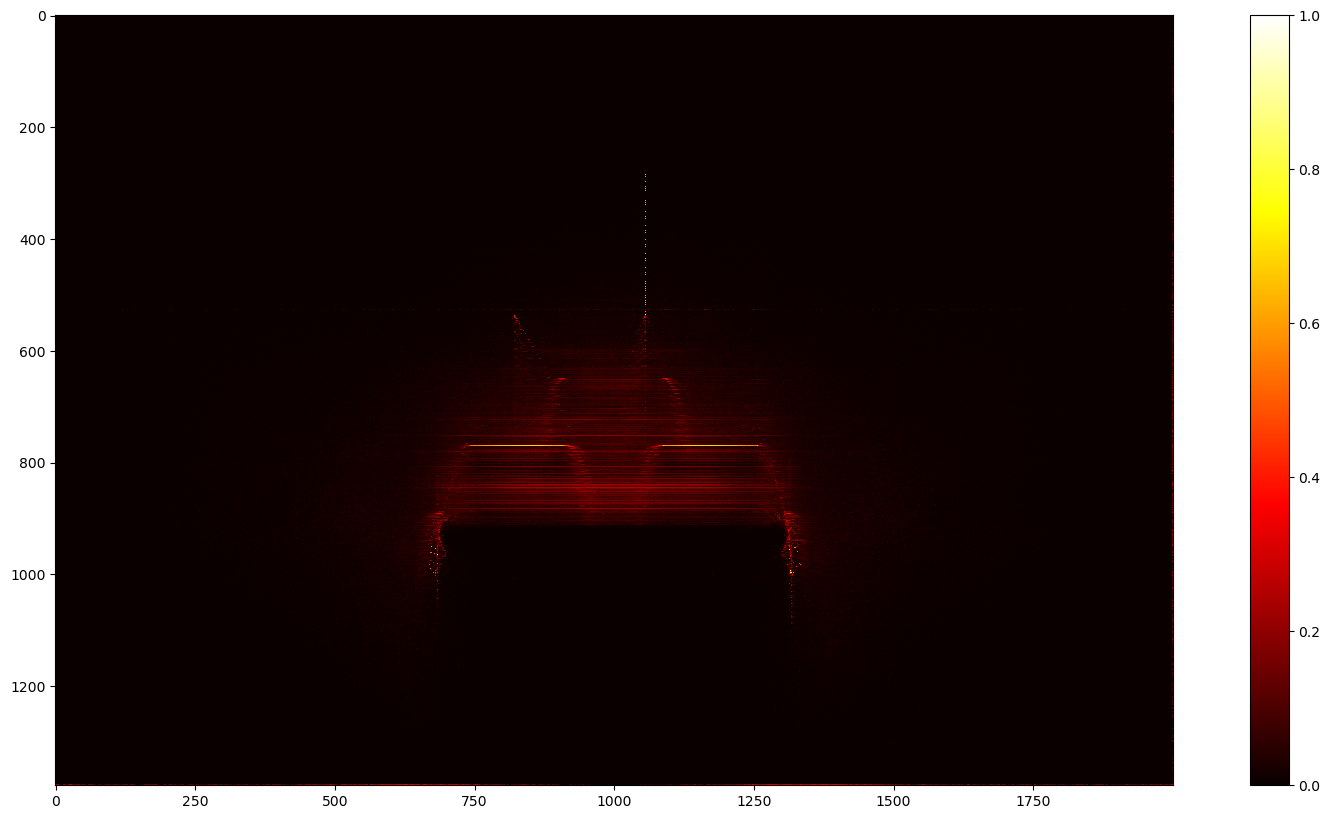

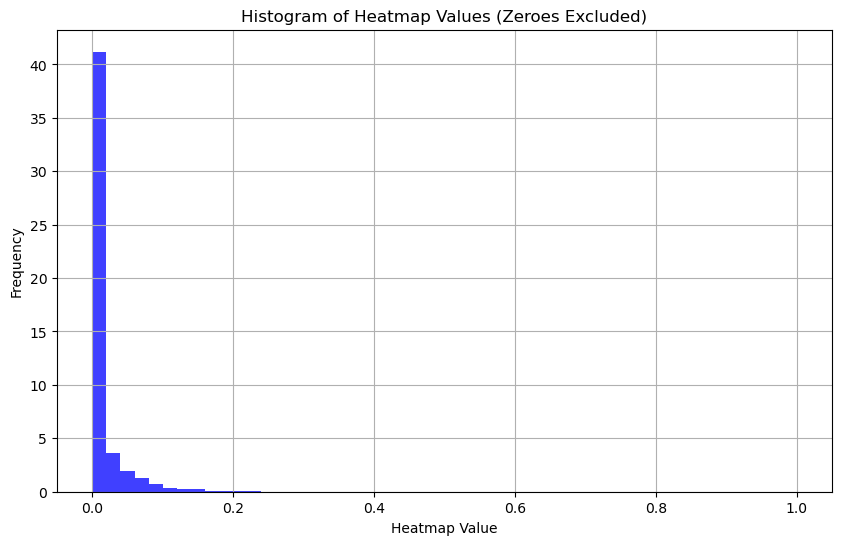

In [26]:
stage_name = 'BATTLEFIELD'
num_files = -1

file_paths = falco_df[all_games_df['stage_name'] == stage_name]['opponent_all_data_df_path'].to_list()
num_horizontal_pixels = 2000

manager = Manager()
heat_map_list = manager.list()

# Use joblib to parallelize heat map creation
Parallel(n_jobs=20, verbose=1)(delayed(joblib_location_heat_map)(file_path, stage_name, num_horizontal_pixels, blast_zones_df, heat_map_list) for file_path in tqdm.tqdm(file_paths[:num_files]))

sum_heat_map = sum(heat_map_list)

log_heat_map = apply_log_transformation(sum_heat_map)
display_heat_map(log_heat_map)
display_heat_map_histogram(log_heat_map)

C:\Users\jaspa\AppData\Local\Temp\ipykernel_19028\2025668201.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  file_paths = falco_df[all_games_df['stage_name'] == stage_name]['opponent_all_data_df_path'].to_list()

[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.

[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.3s







[Parallel(n_jobs=20)]: Done 160 tasks      | elapsed:    2.9s













[Parallel(n_jobs=20)]: Done 410 tasks      | elapsed:    6.8s

















[Parallel(n_jobs=20)]: Done 760 tasks      | elapsed:   11.6s























[Parallel(n_jobs=20)]: Done 1210 tasks      | elapsed:   18.5s



























[Parallel(n_jobs=20)]: Done 1760 tasks      | elapsed:   28.1s

































[Parallel(n_jobs=20)]: Done 2410 tasks      | elapsed:   39.2s













100%|██████████| 2718/2718 [00:43<00:00, 62.52it/s]
[Parallel(n_jobs=20)]: Done 2718 out of 2718 | elap

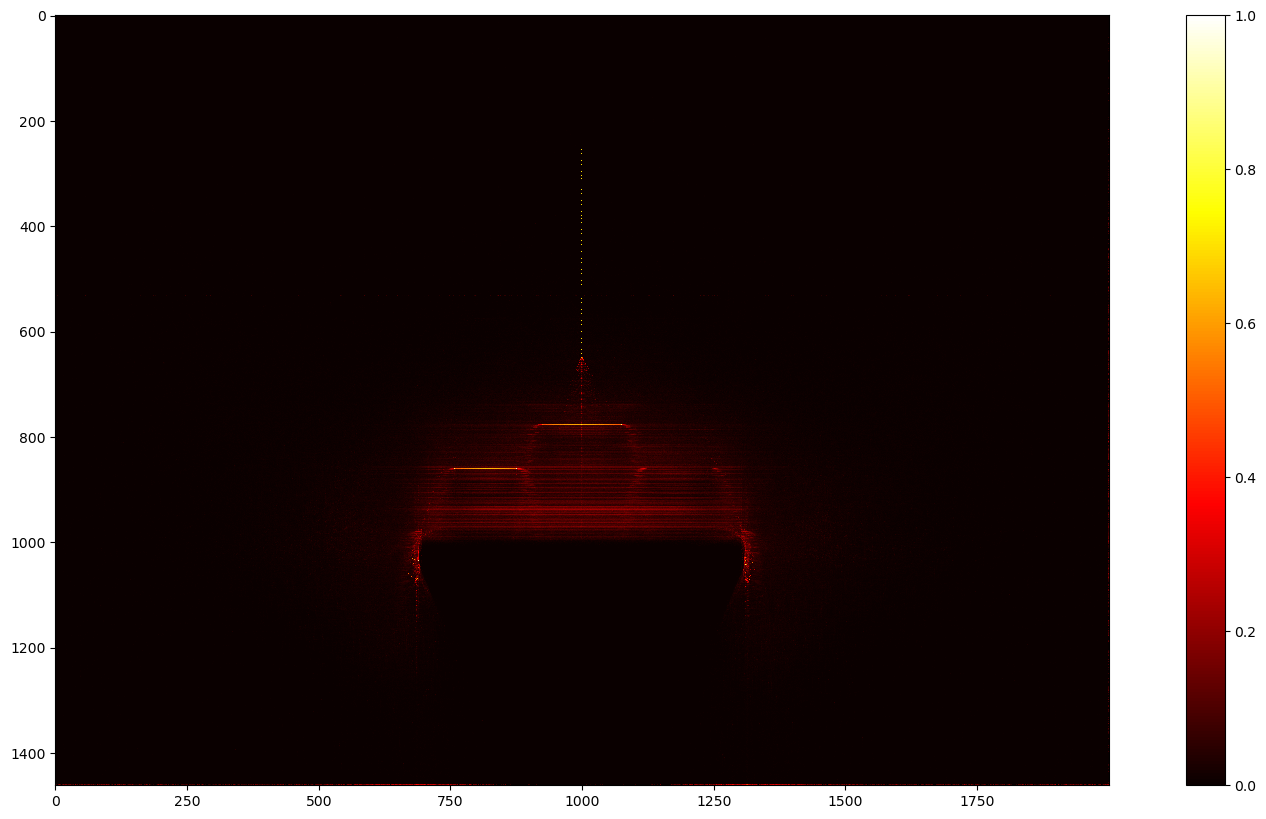

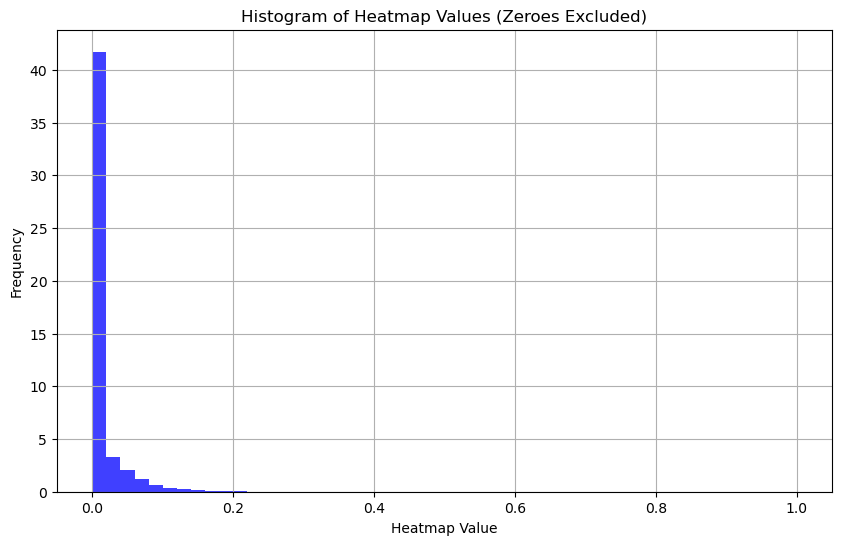

In [27]:
stage_name = 'DREAM_LAND_N64'
num_files = -1

file_paths = falco_df[all_games_df['stage_name'] == stage_name]['opponent_all_data_df_path'].to_list()
num_horizontal_pixels = 2000

del heat_map_list
manager = Manager()
heat_map_list = manager.list()

# Use joblib to parallelize heat map creation
Parallel(n_jobs=20, verbose=1)(delayed(joblib_location_heat_map)(file_path, stage_name, num_horizontal_pixels, blast_zones_df, heat_map_list) for file_path in tqdm.tqdm(file_paths[:num_files]))

sum_heat_map = sum(heat_map_list)

log_heat_map = apply_log_transformation(sum_heat_map)
display_heat_map(log_heat_map)
display_heat_map_histogram(log_heat_map)


C:\Users\jaspa\AppData\Local\Temp\ipykernel_19028\216781686.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  file_paths = falco_df[all_games_df['stage_name'] == stage_name]['opponent_all_data_df_path'].to_list()

[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.

[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.3s







[Parallel(n_jobs=20)]: Done 160 tasks      | elapsed:    2.5s













[Parallel(n_jobs=20)]: Done 410 tasks      | elapsed:    5.7s

















[Parallel(n_jobs=20)]: Done 760 tasks      | elapsed:    9.9s























[Parallel(n_jobs=20)]: Done 1210 tasks      | elapsed:   16.9s



























[Parallel(n_jobs=20)]: Done 1760 tasks      | elapsed:   25.6s































100%|██████████| 2417/2417 [00:33<00:00, 71.60it/s]
[Parallel(n_jobs=20)]: Done 2417 out of 2417 | elapsed:   34.5s finished


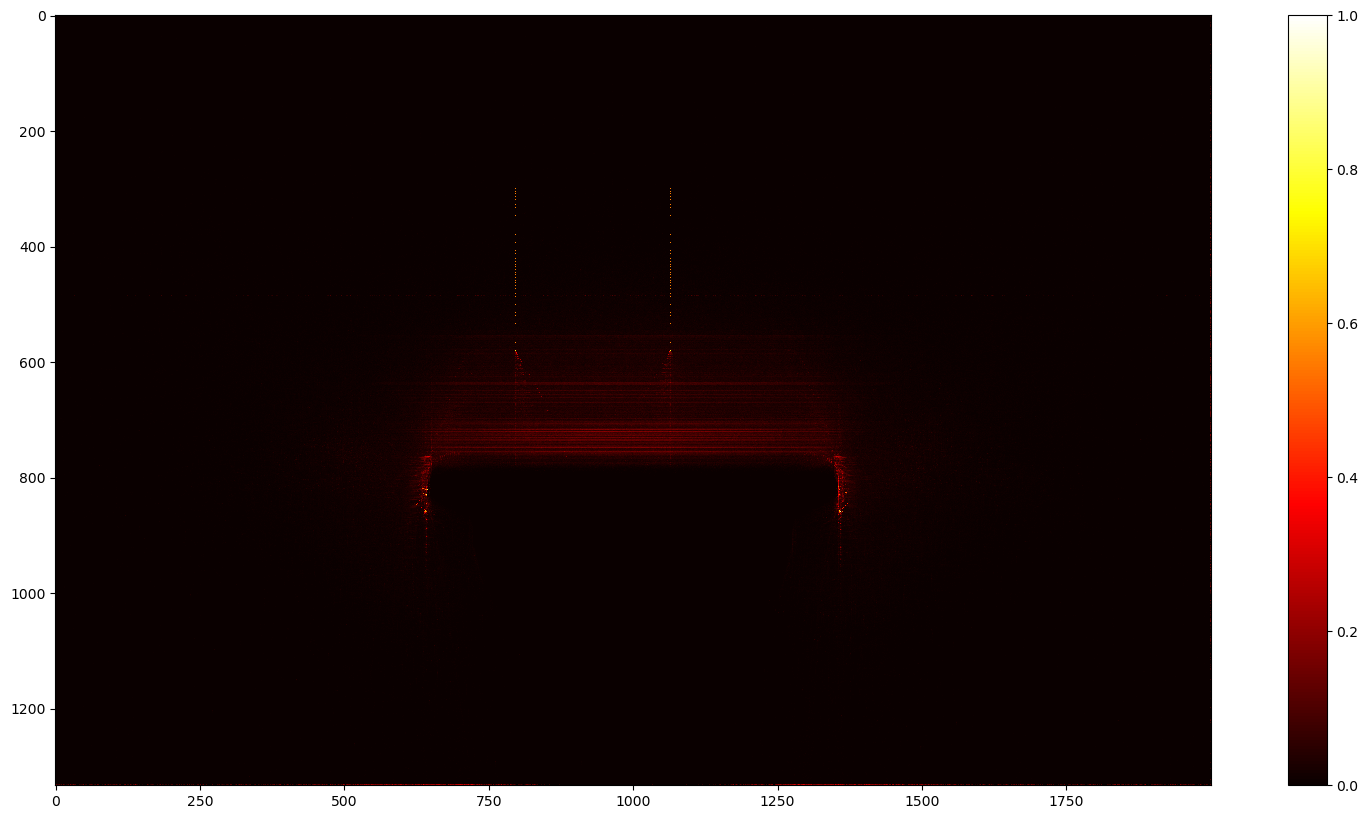

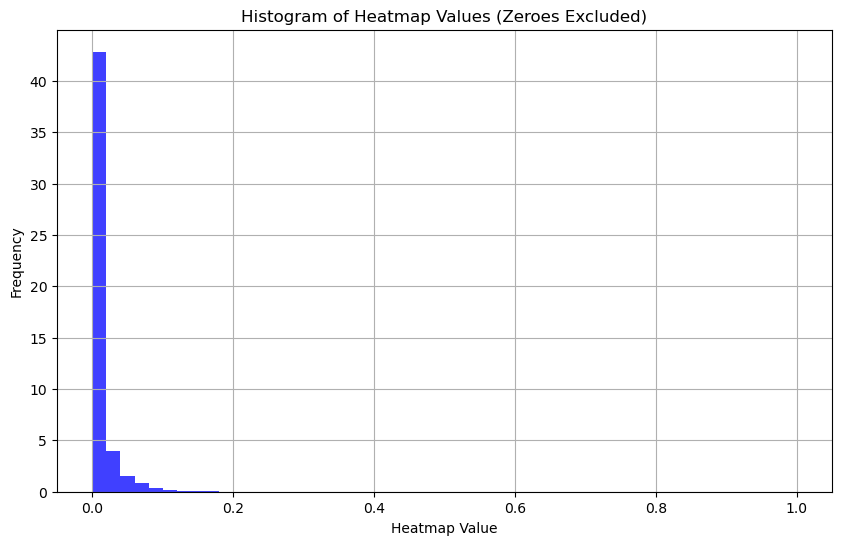

In [28]:
stage_name = 'FINAL_DESTINATION'
num_files = -1

file_paths = falco_df[all_games_df['stage_name'] == stage_name]['opponent_all_data_df_path'].to_list()
num_horizontal_pixels = 2000

del heat_map_list
manager = Manager()
heat_map_list = manager.list()

# Use joblib to parallelize heat map creation
Parallel(n_jobs=20, verbose=1)(delayed(joblib_location_heat_map)(file_path, stage_name, num_horizontal_pixels, blast_zones_df, heat_map_list) for file_path in tqdm.tqdm(file_paths[:num_files]))

sum_heat_map = sum(heat_map_list)

log_heat_map = apply_log_transformation(sum_heat_map)
display_heat_map(log_heat_map)
display_heat_map_histogram(log_heat_map)

C:\Users\jaspa\AppData\Local\Temp\ipykernel_19028\1811646874.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  file_paths = falco_df[all_games_df['stage_name'] == stage_name]['opponent_all_data_df_path'].to_list()

[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.

[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.5s







[Parallel(n_jobs=20)]: Done 160 tasks      | elapsed:    3.4s













[Parallel(n_jobs=20)]: Done 410 tasks      | elapsed:    7.7s

















[Parallel(n_jobs=20)]: Done 760 tasks      | elapsed:   13.2s























[Parallel(n_jobs=20)]: Done 1210 tasks      | elapsed:   22.2s



























[Parallel(n_jobs=20)]: Done 1760 tasks      | elapsed:   32.7s
































100%|██████████| 2436/2436 [00:44<00:00, 54.80it/s]
[Parallel(n_jobs=20)]: Done 2436 out of 2436 | elapsed:   45.3s finished


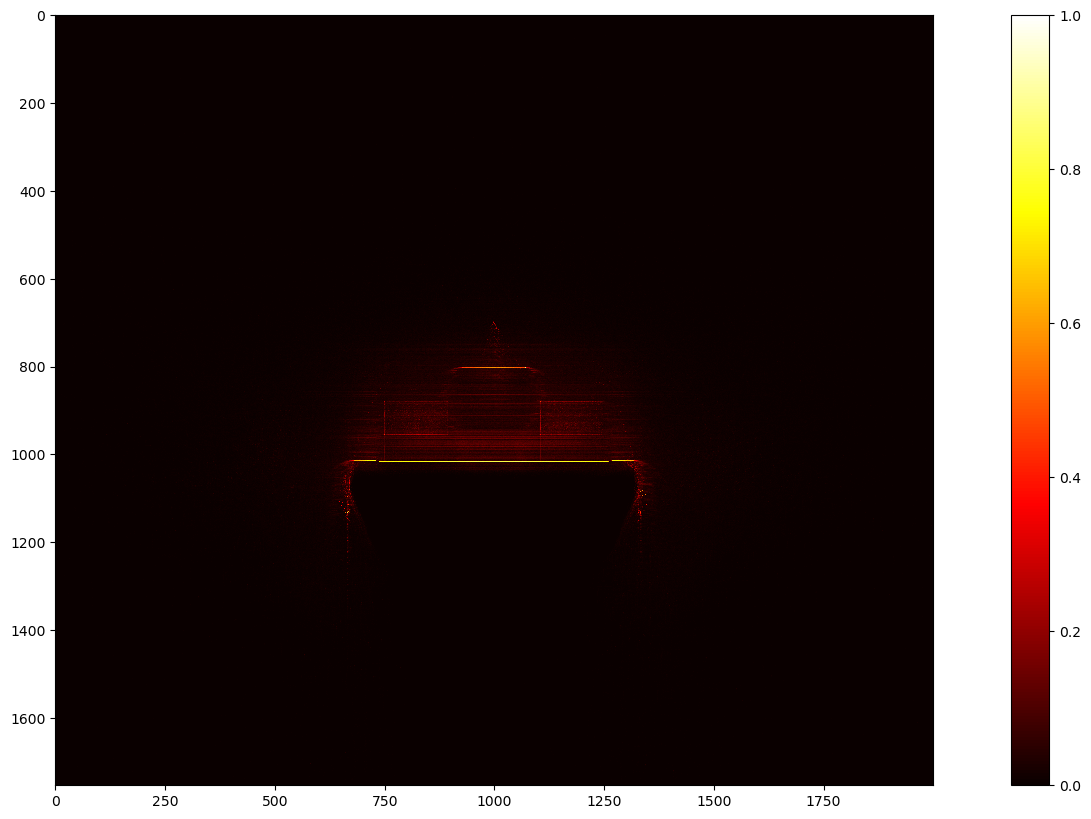

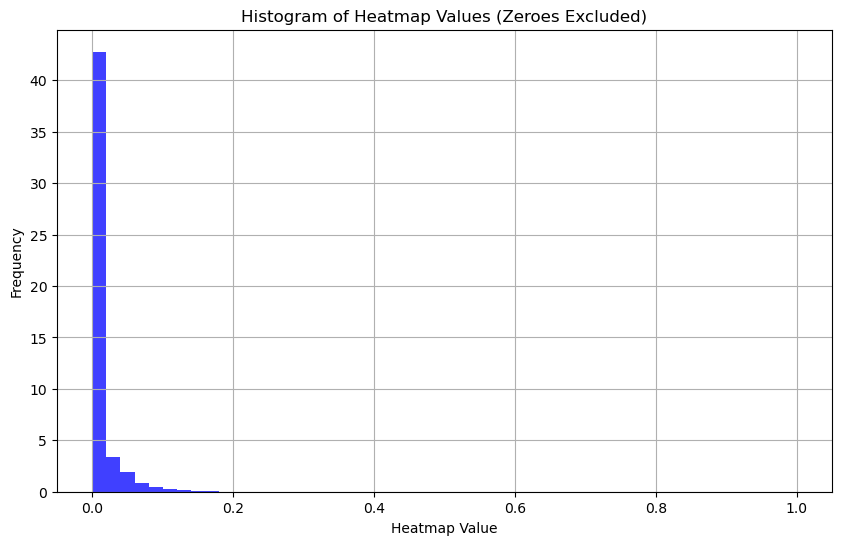

In [29]:
stage_name = 'FOUNTAIN_OF_DREAMS'
num_files = -1

file_paths = falco_df[all_games_df['stage_name'] == stage_name]['opponent_all_data_df_path'].to_list()
num_horizontal_pixels = 2000

del heat_map_list
manager = Manager()
heat_map_list = manager.list()

# Use joblib to parallelize heat map creation
Parallel(n_jobs=20, verbose=1)(delayed(joblib_location_heat_map)(file_path, stage_name, num_horizontal_pixels, blast_zones_df, heat_map_list) for file_path in tqdm.tqdm(file_paths[:num_files]))

sum_heat_map = sum(heat_map_list)

log_heat_map = apply_log_transformation(sum_heat_map)
display_heat_map(log_heat_map)
display_heat_map_histogram(log_heat_map)

C:\Users\jaspa\AppData\Local\Temp\ipykernel_19028\3291107862.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  file_paths = falco_df[all_games_df['stage_name'] == stage_name]['opponent_all_data_df_path'].to_list()

[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.

[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.4s







[Parallel(n_jobs=20)]: Done 160 tasks      | elapsed:    3.0s













[Parallel(n_jobs=20)]: Done 410 tasks      | elapsed:    7.3s

















[Parallel(n_jobs=20)]: Done 760 tasks      | elapsed:   12.4s























[Parallel(n_jobs=20)]: Done 1210 tasks      | elapsed:   20.7s



























[Parallel(n_jobs=20)]: Done 1760 tasks      | elapsed:   31.3s

































[Parallel(n_jobs=20)]: Done 2410 tasks      | elapsed:   43.9s













100%|██████████| 2700/2700 [00:49<00:00, 55.03it/s]
[Parallel(n_jobs=20)]: Done 2700 out of 2700 | elap

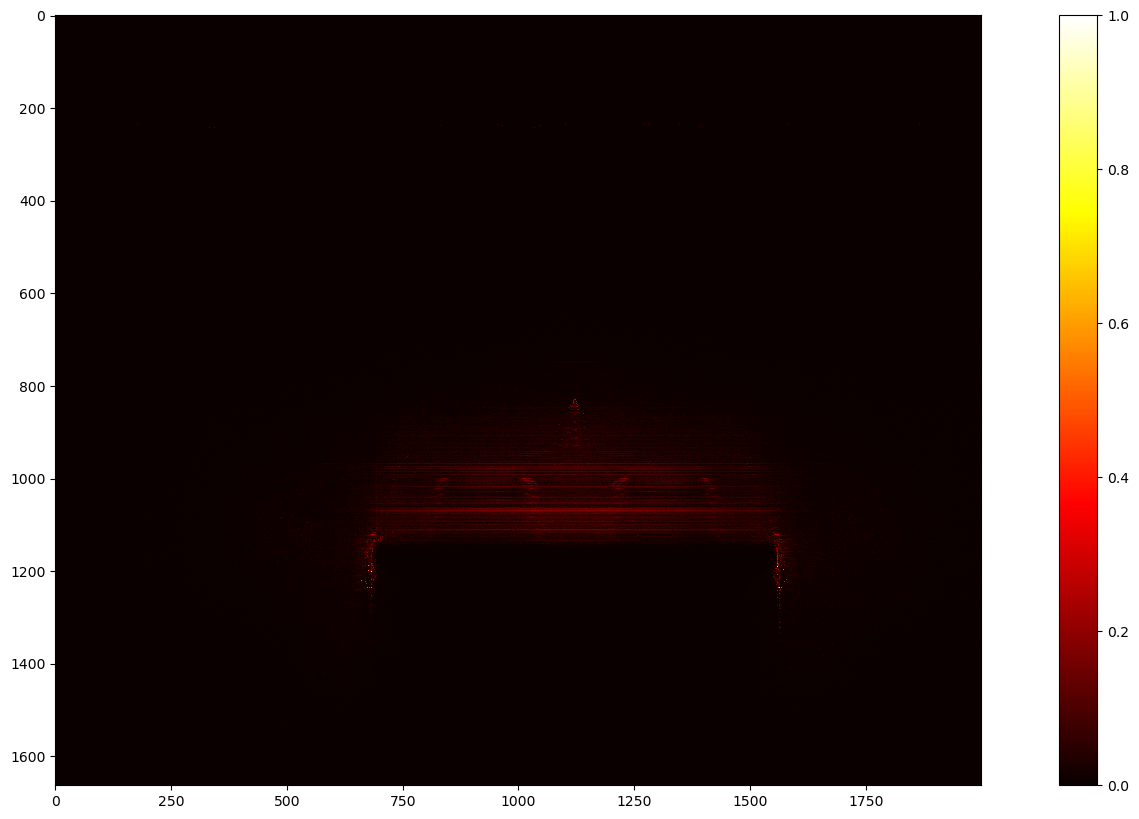

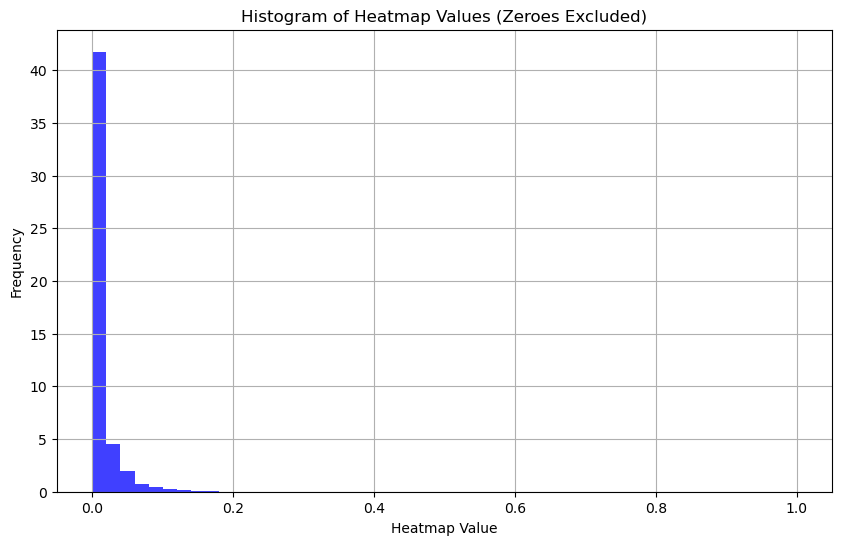

In [30]:
stage_name = 'POKEMON_STADIUM'
num_files = -1

file_paths = falco_df[all_games_df['stage_name'] == stage_name]['opponent_all_data_df_path'].to_list()
num_horizontal_pixels = 2000

del heat_map_list
manager = Manager()
heat_map_list = manager.list()

# Use joblib to parallelize heat map creation
Parallel(n_jobs=20, verbose=1)(delayed(joblib_location_heat_map)(file_path, stage_name, num_horizontal_pixels, blast_zones_df, heat_map_list) for file_path in tqdm.tqdm(file_paths[:num_files]))

sum_heat_map = sum(heat_map_list)

log_heat_map = apply_log_transformation(sum_heat_map)
display_heat_map(log_heat_map)
display_heat_map_histogram(log_heat_map)

C:\Users\jaspa\AppData\Local\Temp\ipykernel_19028\31657488.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  file_paths = falco_df[all_games_df['stage_name'] == stage_name]['opponent_all_data_df_path'].to_list()

[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.

[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.4s







[Parallel(n_jobs=20)]: Done 160 tasks      | elapsed:    3.0s













[Parallel(n_jobs=20)]: Done 410 tasks      | elapsed:    6.6s

















[Parallel(n_jobs=20)]: Done 760 tasks      | elapsed:   11.7s























[Parallel(n_jobs=20)]: Done 1210 tasks      | elapsed:   19.6s



























[Parallel(n_jobs=20)]: Done 1760 tasks      | elapsed:   28.8s

































[Parallel(n_jobs=20)]: Done 2410 tasks      | elapsed:   39.1s



















100%|██████████| 2829/2829 [00:45<00:00, 62.72it/s]
[Parallel(n_jobs=20)]: Done 2829 out of 2829 | 

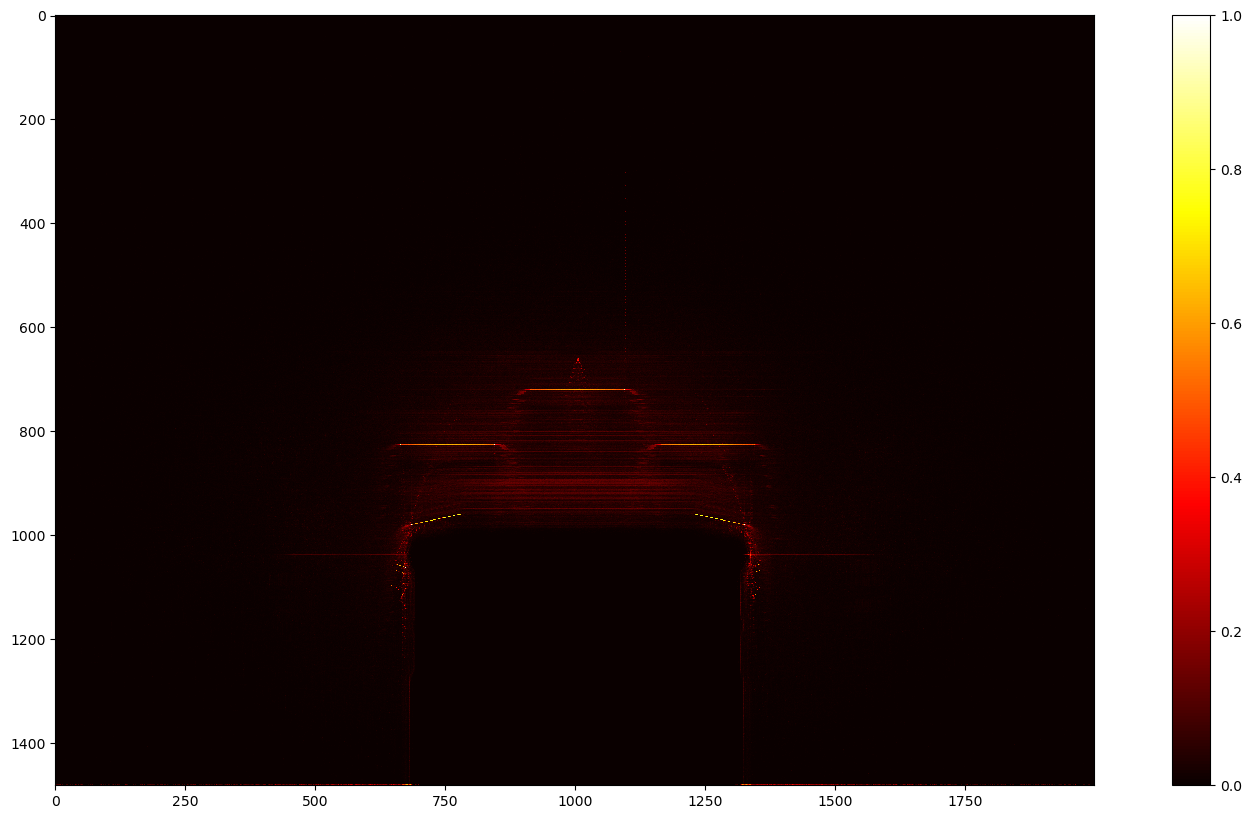

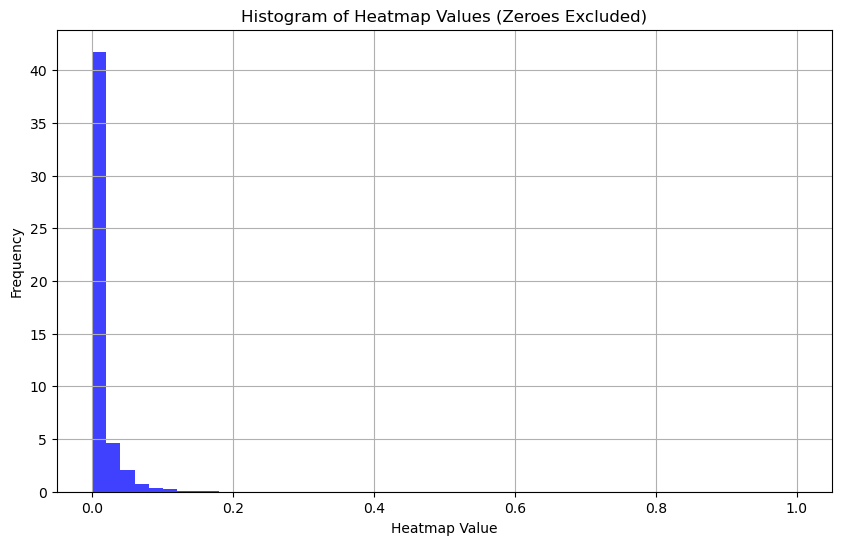

In [31]:
stage_name = 'YOSHIS_STORY'
num_files = -1

file_paths = falco_df[all_games_df['stage_name'] == stage_name]['opponent_all_data_df_path'].to_list()
num_horizontal_pixels = 2000

del heat_map_list
manager = Manager()
heat_map_list = manager.list()

# Use joblib to parallelize heat map creation
Parallel(n_jobs=20, verbose=1)(delayed(joblib_location_heat_map)(file_path, stage_name, num_horizontal_pixels, blast_zones_df, heat_map_list) for file_path in tqdm.tqdm(file_paths[:num_files]))

sum_heat_map = sum(heat_map_list)

log_heat_map = apply_log_transformation(sum_heat_map)
display_heat_map(log_heat_map)
display_heat_map_histogram(log_heat_map)